## Cargamos los datos de life expentancy

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv("./data/life_expectancy.csv")
# Display the first few rows of the DataFrame
print(df.head().to_string())



       Country  Year      Status  LifeExpectancy  AdultMortality  InfantDeaths  Alcohol  percentExpenditure  HepatitisB  Measles   BMI  underfiveDeaths  Polio  Total expenditure  Diphtheria  HIV/AIDS         GDP  Population  thinness1-19  thinness5-9  Income  Schooling
0  Afghanistan  2015  Developing            65.0           263.0            62     0.01           71.279624        65.0     1154  19.1               83    6.0               8.16        65.0       0.1  584.259210  33736494.0          17.2         17.3   0.479       10.1
1  Afghanistan  2014  Developing            59.9           271.0            64     0.01           73.523582        62.0      492  18.6               86   58.0               8.18        62.0       0.1  612.696514    327582.0          17.5         17.5   0.476       10.0
2  Afghanistan  2013  Developing            59.9           268.0            66     0.01           73.219243        64.0      430  18.1               89   62.0               8.13        64.0 

## Analisis de los datos

In [2]:
# Dimensiones y tipos de datos
print(f"Forma del dataframe {df.shape}")
print(f"Tipos de datos en el dataframe \n{df.dtypes}")

# Porcentaje de valores nulos por columna
missing_pct = df.isnull().mean().sort_values(ascending=False) * 100
print("\nPorcentaje de valores nulos por columna:")
print(missing_pct[missing_pct > 0].to_string() + "%")



Forma del dataframe (2938, 22)
Tipos de datos en el dataframe 
Country                object
Year                    int64
Status                 object
LifeExpectancy        float64
AdultMortality        float64
InfantDeaths            int64
Alcohol               float64
percentExpenditure    float64
HepatitisB            float64
Measles                 int64
BMI                   float64
underfiveDeaths         int64
Polio                 float64
Total expenditure     float64
Diphtheria            float64
HIV/AIDS              float64
GDP                   float64
Population            float64
thinness1-19          float64
thinness5-9           float64
Income                float64
Schooling             float64
dtype: object

Porcentaje de valores nulos por columna:
Population           22.191967
HepatitisB           18.822328
GDP                  15.248468
Total expenditure     7.692308
Alcohol               6.603131
Income                5.684139
Schooling             5.547992
thin

## Preparando el pipeline de prepocesado de datos.

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 1. Separar X e y
df = df.dropna(subset=['LifeExpectancy'])  # Eliminar filas con valores nulos en 'LifeExpectancy'
X = df.drop(columns=['LifeExpectancy'])
y = df['LifeExpectancy']


# 2. Eliminar columna 'Country'
features_to_keep = X.columns.drop(['Country','Status'])

# 3. Pipeline para columnas numéricas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 4. ColumnTransformer que aplica num_pipeline solo a features_to_keep
preprocessor = ColumnTransformer([
    ('num', num_pipeline, features_to_keep)
], remainder='drop')  # Esto asegura que 'Country' se elimina

# 5. (Listo para usar en un Pipeline final cuando quieras entrenar un modelo)

# Observar la correlacion de las features

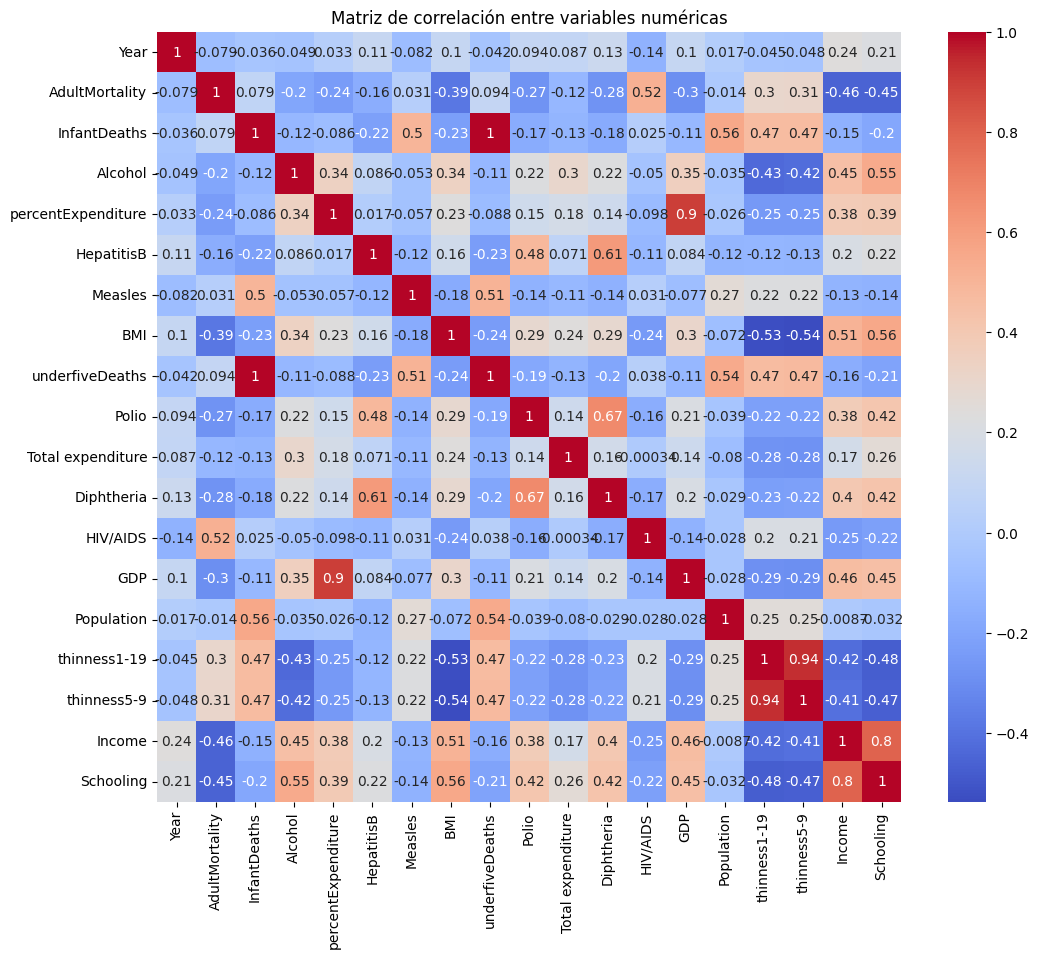

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[features_to_keep].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación entre variables numéricas")
plt.show()


In [5]:
import numpy as np

# Triángulo superior de la matriz para evitar duplicados
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Variables con correlación > 0.9
high_corr = [column for column in upper.columns if any(upper[column] > 0.9)]

print("Variables altamente correladas:", high_corr)


Variables altamente correladas: ['underfiveDeaths', 'thinness5-9']


### Limpieza de las columnas que correlan demasiado.

In [6]:
# Columnas numéricas sin las altamente correladas
features_cleaned = features_to_keep.drop(high_corr)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, features_cleaned)
], remainder='drop')


### Creación del pipeline final

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Pipeline completo: preprocesamiento + modelo
model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])


### Separación de los datos

In [8]:
from utils import split_data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y,stratify=False, random_state=42)
X_transformed = preprocessor.fit_transform(X_train)
#Formato de los datos
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"X_transformed: {X_transformed.shape}")

X_train: (1756, 21), y_train: (1756,)
X_val: (586, 21), y_val: (586,)
X_test: (586, 21), y_test: (586,)
X_transformed: (1756, 17)


## Entranamiento y validacion del modelo

0

📈 Evaluación del modelo de regresión
RMSE: 2.03
MAE:  1.28
R²:   0.9550


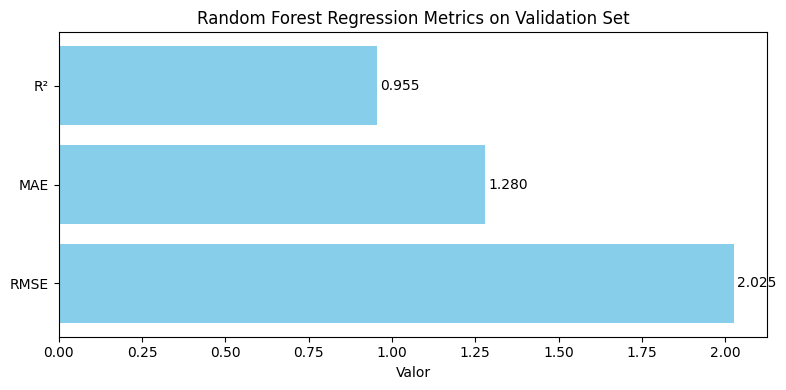

In [9]:
import pandas as pd
from utils import evaluate_regression_metrics,plot_regression_metrics
print(y_train.isnull().sum())

model_pipeline.fit(X_train, y_train)

y_val_pred = model_pipeline.predict(X_val)
random_forest_metrics = evaluate_regression_metrics(y_val, y_val_pred)

plot_regression_metrics(random_forest_metrics, title='Random Forest Regression Metrics on Validation Set')


## Ahora comprobamos los resultados en test


📈 Evaluación del modelo de regresión
RMSE: 1.83
MAE:  1.17
R²:   0.9611


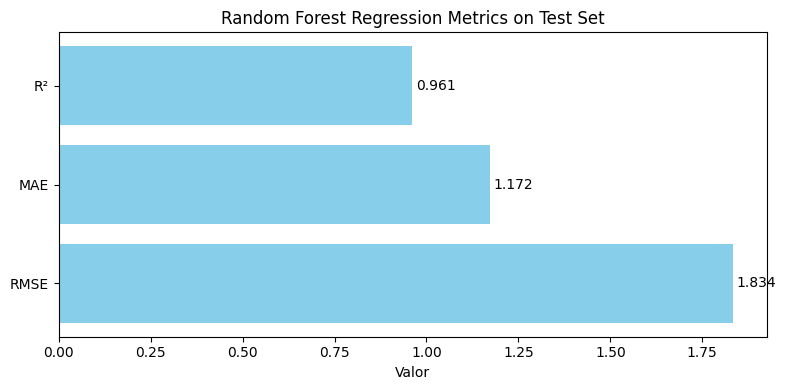

In [10]:
y_test_pred = model_pipeline.predict(X_test)
test_metrics = evaluate_regression_metrics(y_test, y_test_pred)
plot_regression_metrics(test_metrics, title='Random Forest Regression Metrics on Test Set')

### Comprobando resultados con train


📈 Evaluación del modelo de regresión
RMSE: 0.75
MAE:  0.47
R²:   0.9939


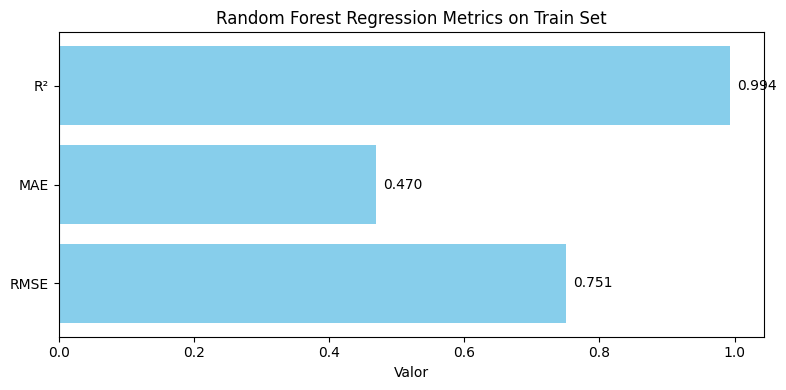

In [11]:
y_train_pred = model_pipeline.predict(X_train)
train_metrics = evaluate_regression_metrics(y_train, y_train_pred)
plot_regression_metrics(train_metrics, title='Random Forest Regression Metrics on Train Set')


## Ajustando los hiperparametros con RandomizedSearch

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Rango de hiperparámetros
param_distributions = {
    'regressor__n_estimators': randint(100, 250),
    'regressor__max_depth': randint(15, 30),
    'regressor__min_samples_split': randint(5, 9),
    'regressor__min_samples_leaf': randint(1, 2),
    'regressor__max_features': ['sqrt', 'log2']
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=60,
    scoring='neg_root_mean_squared_error',  # para RMSE
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

📈 Evaluación del modelo de regresión
RMSE: 2.14
MAE:  1.43
R²:   0.9497


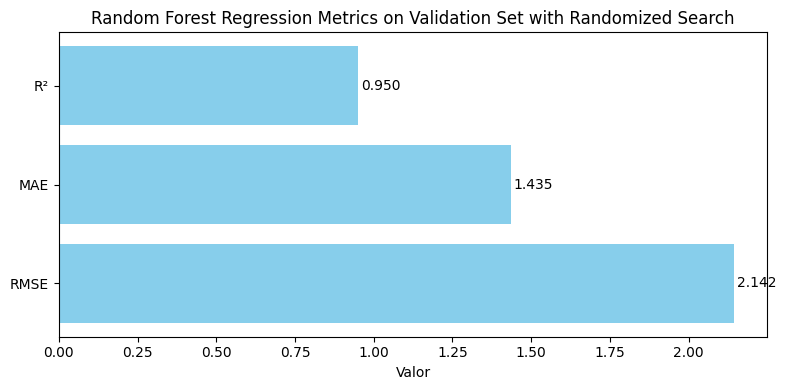

,RMSE,std_test_score,regressor__max_depth,regressor__max_features,regressor__min_samples_leaf,regressor__min_samples_split,regressor__n_estimators
0,2.190518,0.200813,15,sqrt,1,5,230
1,2.191943,0.198607,18,sqrt,1,5,102
2,2.197634,0.195939,18,log2,1,5,242
3,2.197712,0.201650,28,sqrt,1,5,233
4,2.198041,0.202564,23,log2,1,5,235


In [13]:
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Predecir y evaluar como antes
y_val_pred = best_model.predict(X_val)
metrics_Randomized_search =evaluate_regression_metrics(y_val, y_val_pred)
plot_regression_metrics(metrics_Randomized_search, title='Random Forest Regression Metrics on Validation Set with Randomized Search')

# Convertir resultados en DataFrame
results_df = pd.DataFrame(random_search.cv_results_)

# Convertir la métrica negativa en RMSE positivo
results_df['RMSE'] = -results_df['mean_test_score']

# Expandir los parámetros del diccionario en columnas separadas
params_df = results_df['params'].apply(pd.Series)

# Combinar todo en un solo DataFrame
full_df = pd.concat([results_df[['RMSE', 'std_test_score']], params_df], axis=1)

# Ordenar por RMSE y mostrar los 5 mejores
top5_df = full_df.sort_values(by='RMSE').head(5)
top5_df.reset_index(drop=True, inplace=True)

# Mostrar
top5_df

# Resolviendolo con redNeuronal

Aplicamos el preprocesamiento a los datos pero solo al primero aplicamos el fit_transform

In [14]:
# Transformar X con el preprocessor entrenado
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)
X_test_proc  = preprocessor.transform(X_test)
print(f"X_train_proc: {X_train_proc.shape}, X_val_proc: {X_val_proc.shape}, X_test_proc: {X_test_proc.shape}")


X_train_proc: (1756, 17), X_val_proc: (586, 17), X_test_proc: (586, 17)


Creacion de los dataloaders


In [15]:
from utils import create_dataloaders
dataloaders = create_dataloaders(X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test)

Creacion del modelo neuronal

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class LifeExpectancyNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(p=0.3)
        
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(p=0.2)
        
        self.fc3 = nn.Linear(64, 32)
        
        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = F.relu(self.fc3(x))
        return self.out(x)


In [17]:
from utils import train_regression_model, evaluate_regression_metrics, plot_regression_metrics
import torch.optim as optim
import torch

input_dim = X_train_proc.shape[1]
model_pipeline = LifeExpectancyNN(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_pipeline.parameters(), lr=0.001)
train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']
metrics_neural_net = train_regression_model(model_pipeline, train_loader, val_loader, criterion, optimizer, epochs=100, device='cpu', log_every=10)


🚀 Entrenando red neuronal de regresión (100 epochs)...

Epoch 10/100 | Train Loss: 147.4818 | Val Loss: 80.8485 | Train R²: -0.6180 | Val R²: 0.0726
Epoch 20/100 | Train Loss: 104.4221 | Val Loss: 46.2708 | Train R²: -0.1291 | Val R²: 0.4747
Epoch 30/100 | Train Loss: 79.9740 | Val Loss: 33.7784 | Train R²: 0.1270 | Val R²: 0.6216
Epoch 40/100 | Train Loss: 70.2256 | Val Loss: 24.5817 | Train R²: 0.2335 | Val R²: 0.7259
Epoch 50/100 | Train Loss: 65.5319 | Val Loss: 19.6392 | Train R²: 0.2820 | Val R²: 0.7823
Epoch 60/100 | Train Loss: 56.8837 | Val Loss: 19.0083 | Train R²: 0.3817 | Val R²: 0.7880
Epoch 70/100 | Train Loss: 53.2223 | Val Loss: 14.8507 | Train R²: 0.4168 | Val R²: 0.8350
Epoch 80/100 | Train Loss: 47.0359 | Val Loss: 13.3603 | Train R²: 0.4889 | Val R²: 0.8520
Epoch 90/100 | Train Loss: 45.0468 | Val Loss: 14.4959 | Train R²: 0.5109 | Val R²: 0.8385
Epoch 100/100 | Train Loss: 37.9656 | Val Loss: 12.9542 | Train R²: 0.5838 | Val R²: 0.8557

✅ Entrenamiento completado.

Graficando los resultados obtenidos


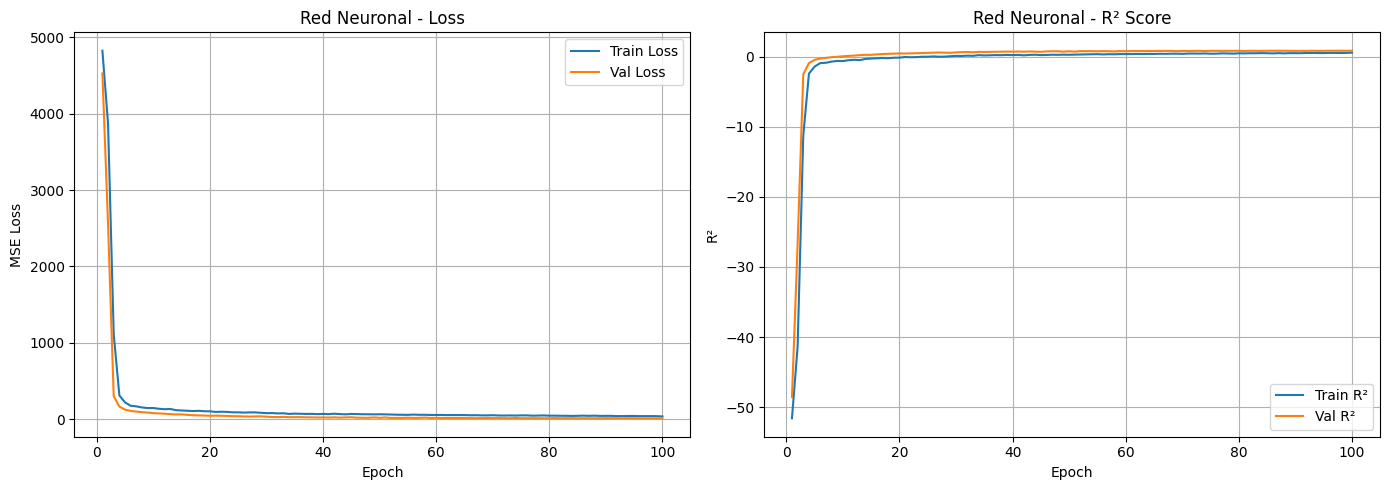

In [18]:
from utils import plot_training_curves
plot_training_curves(metrics_neural_net)

Validacion del modelo

In [19]:
from utils import *
test_metrics_nn = validate_regression_model(model_pipeline, dataloaders['test'])
print(test_metrics_nn)


{'rmse': 3.595745580412617, 'mae': 2.6855489190528012, 'r2': 0.8505262959444729}


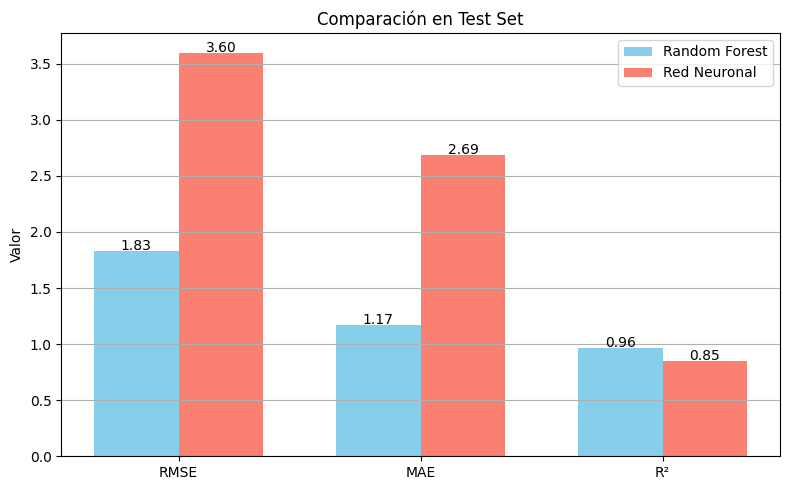

In [21]:
compare_models_plot(test_metrics_nn, test_metrics)
